 # TD 2: Focus on interpretability
 In this practical class, we will implement a method to investigate the importance of the features inputed to
 the classifier, in order to interpret how the classifier has learnt to distinguish healthy controls from depression
 patients using voice only.
 In a first approach, we will only focus on the eGeMAPS features.


## 1 Linear models (*)
In this section (and in this section only), we will use a SVM with a linear kernel.
### 1.1 Read speech
**Task n°1. Implement and evaluate this classifier on the read subcorpus of the Android corpus.**
Since the classifier is linear, it is possible to extract the coefficients of the classifier for each feature.\
**Task n°2. Extract the coefficient of the linear SVM for each fold.**

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/reading_means"):
    """Charge et prépare les données HC et PT du sous-corpus 'reading means'."""
    data_list = []
    labels_list = []
    
    # 1. Charger les données HC (Sains) -> Étiquette 0
    hc_path = os.path.join(base_path, 'HC')
    # Utilisez try-except pour gérer les erreurs si le chemin n'est pas trouvé
    try:
        for filename in os.listdir(hc_path):
            if filename.endswith('.csv'):
                filepath = os.path.join(hc_path, filename)
                df = pd.read_csv(filepath)
                data_list.append(df)
                labels_list.append(0) # Étiquette 0 pour HC
    except FileNotFoundError:
        print(f"Erreur: Le chemin HC n'a pas été trouvé: {hc_path}")
        return np.array([]), np.array([]), [] # Retourne des tableaux vides en cas d'erreur
    except Exception as e:
        print(f"Une erreur s'est produite lors du chargement des données HC : {e}")
        return np.array([]), np.array([]), []

    # 2. Charger les données PT (Malades) -> Étiquette 1
    pt_path = os.path.join(base_path, 'PT')
    try:
        for filename in os.listdir(pt_path):
            if filename.endswith('.csv'):
                filepath = os.path.join(pt_path, filename)
                df = pd.read_csv(filepath)
                data_list.append(df)
                labels_list.append(1) # Étiquette 1 pour PT
    except FileNotFoundError:
        print(f"Erreur: Le chemin PT n'a pas été trouvé: {pt_path}")
        return np.array([]), np.array([]), []
    except Exception as e:
        print(f"Une erreur s'est produite lors du chargement des données PT : {e}")
        return np.array([]), np.array([]), []

    # Vérifiez si des données ont été chargées
    if not data_list:
        print("Aucun fichier CSV trouvé ou les chemins d'accès sont incorrects.")
        return np.array([]), np.array([]), []

    # --- Option 1 : Chaque ligne est un exemple indépendant ---
    # Concaténation des DataFrames
    X_full = pd.concat(data_list, ignore_index=True)
    
    # Création du vecteur d'étiquettes
    y_full = np.concatenate([[label] * len(data) for data, label in zip(data_list, labels_list)])

    # 4. Séparer Features (X) et Labels (y) et nettoyer les colonnes
    columns_to_drop = ['file', 'start', 'end']
    
    # Assurez-vous que les colonnes existent avant de les supprimer
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    # Sauvegarde des noms de features
    feature_names = X.columns.tolist()
    
    # Conversion en numpy array
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION DE CLASSIFICATION ET ÉVALUATION ---
def test_k_folds_android():
    # 1. Chargement des données 
    X, y, feature_names = load_and_preprocess_data()
    
    # Vérification du chargement
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. Initialisation du classifieur
    # SVC avec un noyau linéaire est un classifieur linéaire.
    clf = SVC(kernel='linear', C=1, random_state=42)
    
    # 3. Validation Croisée (cv=5)
    # return_estimator=True est essentiel pour récupérer les modèles entraînés
    cv_results = cross_validate(
        clf, X, y, 
        cv=5, 
        scoring='accuracy', 
        return_estimator=True
    )
    
    # 4. Évaluation
    mean_accuracy = cv_results["test_score"].mean()
    print("\n--- ÉVALUATION PAR VALIDATION CROISÉE ---")
    print(f"Précision moyenne (5-Fold CV): {mean_accuracy:.4f}")
    
    # ----------------------------------------------------------------------------------
    # 5. Extraction et Analyse des Coefficients (MIS À JOUR)
    # ----------------------------------------------------------------------------------
    
    print("\n--- ANALYSE DES COEFFICIENTS DU CLASSIFIEUR PAR PLI ---")
    
    # Récupérer les 5 classifieurs entraînés
    estimators = cv_results["estimator"]
    
    # Liste pour stocker les DataFrames de coefficients par pli
    fold_coeffs_dfs = []
    all_coeffs = []

    # Itérer sur chaque estimateur entraîné
    for i, estimator in enumerate(estimators):
        fold_coeffs = estimator.coef_.flatten()
        all_coeffs.append(fold_coeffs)
        
        # Créer un DataFrame pour ce pli
        fold_df = pd.DataFrame({
            'Feature': feature_names,
            f'Fold_{i+1}_Coefficient': fold_coeffs 
        })
        fold_coeffs_dfs.append(fold_df.set_index('Feature'))
        
        # Affichage du top/bottom 3 pour le pli actuel
        print(f"\nCoefficients du Pli {i+1} (Top/Bottom 3) :")
        print(fold_df.sort_values(by=f'Fold_{i+1}_Coefficient', ascending=False).head(3))
        print(fold_df.sort_values(by=f'Fold_{i+1}_Coefficient', ascending=False).tail(3))
        

    # Concaténer tous les résultats des plis dans un seul DataFrame
    # Note: L'utilisation de pd.concat avec axis=1 nécessite que l'index (Feature) soit défini
    all_folds_combined_df = pd.concat(fold_coeffs_dfs, axis=1).reset_index()
    
    # Calculer la moyenne des coefficients sur les 5 folds
    mean_coeffs = np.mean(all_coeffs, axis=0)
    
    # Ajouter la moyenne au DataFrame combiné pour une vue complète
    all_folds_combined_df['Mean_Coefficient'] = mean_coeffs

    # Créer un DataFrame pour afficher le Top 5 de la MOYENNE (comme dans votre sortie originale)
    mean_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Coefficient': mean_coeffs
    }).sort_values(by='Mean_Coefficient', ascending=False)
    
    # Affichage des résultats basés sur la moyenne
    print("\n" + "="*50)
    print("--- RÉSULTATS AGRÉGÉS (MOYENNE) ---")
    print(mean_df.head(5).to_string(index=False))
    
    print("\nTop 5 des features avec les coefficients négatifs les plus faibles (Favorise la classe 0 - HC):")
    print(mean_df.tail(5).to_string(index=False))
    print("="*50)
    
    print("\n--- APERÇU DU TABLEAU COMPLET (Coefficients par pli et Moyenne) ---")
    # Afficher les 10 premières lignes du DataFrame complet
    cols_order = ['Feature', 'Mean_Coefficient'] + [col for col in all_folds_combined_df.columns if col.startswith('Fold_')]
    print(all_folds_combined_df[cols_order].head(10).to_string(index=False))


if __name__ == '__main__':
    # Lancez la fonction d'évaluation
    test_k_folds_android()

In [ ]:
--- ÉVALUATION PAR VALIDATION CROISÉE ---
Précision moyenne (5-Fold CV): 0.7051

--- ANALYSE DES COEFFICIENTS DU CLASSIFIEUR PAR PLI ---

Coefficients du Pli 1 (Top/Bottom 3) :
                  Feature  Fold_1_Coefficient
1  pcm_fftMag_mfcc_sma[1]            0.452166
5  pcm_fftMag_mfcc_sma[5]            0.134608
7  pcm_fftMag_mfcc_sma[7]            0.068179
                      Feature  Fold_1_Coefficient
2      pcm_fftMag_mfcc_sma[2]           -0.262979
11    pcm_fftMag_mfcc_sma[11]           -0.311734
15  voicingFinalUnclipped_sma           -1.039469

Coefficients du Pli 2 (Top/Bottom 3) :
                  Feature  Fold_2_Coefficient
1  pcm_fftMag_mfcc_sma[1]            0.682911
7  pcm_fftMag_mfcc_sma[7]            0.102465
8  pcm_fftMag_mfcc_sma[8]            0.044686
                      Feature  Fold_2_Coefficient
12    pcm_fftMag_mfcc_sma[12]           -0.208448
9      pcm_fftMag_mfcc_sma[9]           -0.276033
15  voicingFinalUnclipped_sma           -0.722261

Coefficients du Pli 3 (Top/Bottom 3) :
                  Feature  Fold_3_Coefficient
1  pcm_fftMag_mfcc_sma[1]            0.514670
5  pcm_fftMag_mfcc_sma[5]            0.080158
4  pcm_fftMag_mfcc_sma[4]            0.054710
                      Feature  Fold_3_Coefficient
11    pcm_fftMag_mfcc_sma[11]           -0.224512
9      pcm_fftMag_mfcc_sma[9]           -0.250163
15  voicingFinalUnclipped_sma           -0.908977

Coefficients du Pli 4 (Top/Bottom 3) :
                  Feature  Fold_4_Coefficient
1  pcm_fftMag_mfcc_sma[1]            0.452816
5  pcm_fftMag_mfcc_sma[5]            0.416401
4  pcm_fftMag_mfcc_sma[4]            0.153539
                      Feature  Fold_4_Coefficient
11    pcm_fftMag_mfcc_sma[11]           -0.308381
2      pcm_fftMag_mfcc_sma[2]           -0.543607
15  voicingFinalUnclipped_sma           -0.754028

Coefficients du Pli 5 (Top/Bottom 3) :
                  Feature  Fold_5_Coefficient
1  pcm_fftMag_mfcc_sma[1]            0.655616
4  pcm_fftMag_mfcc_sma[4]            0.115557
3  pcm_fftMag_mfcc_sma[3]            0.080402
                      Feature  Fold_5_Coefficient
11    pcm_fftMag_mfcc_sma[11]           -0.182092
2      pcm_fftMag_mfcc_sma[2]           -0.186645
15  voicingFinalUnclipped_sma           -0.626464

==================================================
--- RÉSULTATS AGRÉGÉS (MOYENNE) ---
                  Feature  Mean_Coefficient
   pcm_fftMag_mfcc_sma[1]          0.551636
   pcm_fftMag_mfcc_sma[5]          0.133121
   pcm_fftMag_mfcc_sma[4]          0.059780
   pcm_fftMag_mfcc_sma[7]          0.027418
pcm_fftMag_mfcc_sma_de[1]          0.016356

Top 5 des features avec les coefficients négatifs les plus faibles (Favorise la classe 0 - HC):
                  Feature  Mean_Coefficient
  pcm_fftMag_mfcc_sma[12]         -0.104335
   pcm_fftMag_mfcc_sma[9]         -0.178184
  pcm_fftMag_mfcc_sma[11]         -0.223027
   pcm_fftMag_mfcc_sma[2]         -0.244147
voicingFinalUnclipped_sma         -0.810240
==================================================

--- APERÇU DU TABLEAU COMPLET (Coefficients par pli et Moyenne) ---
               Feature  Mean_Coefficient  Fold_1_Coefficient  Fold_2_Coefficient  Fold_3_Coefficient  Fold_4_Coefficient  Fold_5_Coefficient
     pcm_RMSenergy_sma         -0.010729           -0.014264           -0.004975           -0.010752           -0.011527           -0.012126
pcm_fftMag_mfcc_sma[1]          0.551636            0.452166            0.682911            0.514670            0.452816            0.655616
pcm_fftMag_mfcc_sma[2]         -0.244147           -0.262979           -0.174009           -0.053497           -0.543607           -0.186645
pcm_fftMag_mfcc_sma[3]         -0.076907           -0.112380           -0.019879           -0.071735           -0.260944            0.080402
pcm_fftMag_mfcc_sma[4]          0.059780            0.030243           -0.055147            0.054710            0.153539            0.115557
pcm_fftMag_mfcc_sma[5]          0.133121            0.134608            0.004453            0.080158            0.416401            0.029985
pcm_fftMag_mfcc_sma[6]         -0.067151            0.036099           -0.056983           -0.133695           -0.019358           -0.161820
pcm_fftMag_mfcc_sma[7]          0.027418            0.068179            0.102465            0.002299           -0.016579           -0.019277
pcm_fftMag_mfcc_sma[8]         -0.027383           -0.002147            0.044686           -0.116850           -0.069985            0.007382
pcm_fftMag_mfcc_sma[9]         -0.178184           -0.223380           -0.276033           -0.250163           -0.124357           -0.016986

**Task n°3. Plot the average relative contribution (%) of each feature with standard-deviation (e.g. using a box plot).**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    _ = all_folds_combined_df 
    print("Utilisation du DataFrame 'all_folds_combined_df' existant.")
except NameError:
    print("Le DataFrame 'all_folds_combined_df' n'est pas défini. Utilisation de données simulées pour le graphique.")

# Les colonnes de coefficients pour le calcul (identifiez-les dynamiquement si possible)
# On suppose que les colonnes de coefficients commencent par 'Fold_' et se terminent par '_Coefficient'
coeff_cols = [col for col in all_folds_combined_df.columns if col.startswith('Fold_') and col.endswith('_Coefficient')]

# S'assurer que 'Feature' est la première colonne pour faciliter le traitement
if 'Feature' in all_folds_combined_df.columns:
    df_plot_data = all_folds_combined_df[['Feature'] + coeff_cols].copy()
else:
    # Si 'Feature' est l'index, le réinitialiser
    df_plot_data = all_folds_combined_df[coeff_cols].copy()
    df_plot_data = df_plot_data.reset_index().rename(columns={'index': 'Feature'})


# Calculer la contribution relative (%) pour chaque pli
df_rel_contrib = df_plot_data[['Feature']].copy()

for col in coeff_cols:
    # Calculer la valeur absolue du coefficient pour la colonne actuelle
    abs_coeffs = df_plot_data[col].abs()
    
    # Calculer la somme totale des contributions absolues pour ce pli.
    # Ajouter une petite constante pour éviter la division par zéro si la somme est 0 (très rare)
    sum_abs_coeffs = abs_coeffs.sum() + 1e-9 # Ajout d'une petite valeur
    
    # Calculer la contribution relative en pourcentage
    df_rel_contrib[f'Relative_Contribution_{col.split("_")[1]}'] = (abs_coeffs / sum_abs_coeffs) * 100

# Mettre les données au format long pour le box plot (seaborn)
# On garde 'Feature' et on met les colonnes de contribution en lignes
df_long = df_rel_contrib.melt(
    id_vars='Feature', 
    value_vars=[col for col in df_rel_contrib.columns if col.startswith('Relative_Contribution')], 
    var_name='Fold', 
    value_name='Contribution (%)'
)

# Calculer la moyenne de la contribution pour trier les features dans le graphique
mean_contributions = df_long.groupby('Feature')['Contribution (%)'].mean().sort_values(ascending=False)
sorted_features = mean_contributions.index

# --- Configuration et Génération du Box Plot ---
plt.figure(figsize=(12, max(6, len(sorted_features) * 0.4))) # Taille dynamique du graphique
sns.boxplot(
    x='Contribution (%)', 
    y='Feature', 
    data=df_long, 
    order=sorted_features, 
    palette="viridis" # Ou une autre palette de couleurs comme "coolwarm", "plasma"
)
plt.title('Contribution Relative Moyenne des Caractéristiques (SVM Linéaire) avec Écart-type', fontsize=14)
plt.xlabel('Contribution Relative (%)', fontsize=12)
plt.ylabel('Caractéristique', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) # Ajoute une grille horizontale
plt.tight_layout() # Ajuste automatiquement les paramètres de la figure pour les marges
plt.show() # Affiche le graphique

# Optionnel : Enregistrer le graphique dans un fichier
# plt.savefig('relative_contribution_boxplot.png', dpi=300) 
# print("Le graphique a été enregistré sous 'relative_contribution_boxplot.png'")

In [ ]:
Utilisation du DataFrame 'all_folds_combined_df' existant.
/var/folders/sz/j46j6kpd5t94xyz4bh0jph9h0000gn/T/ipykernel_67341/1957071531.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

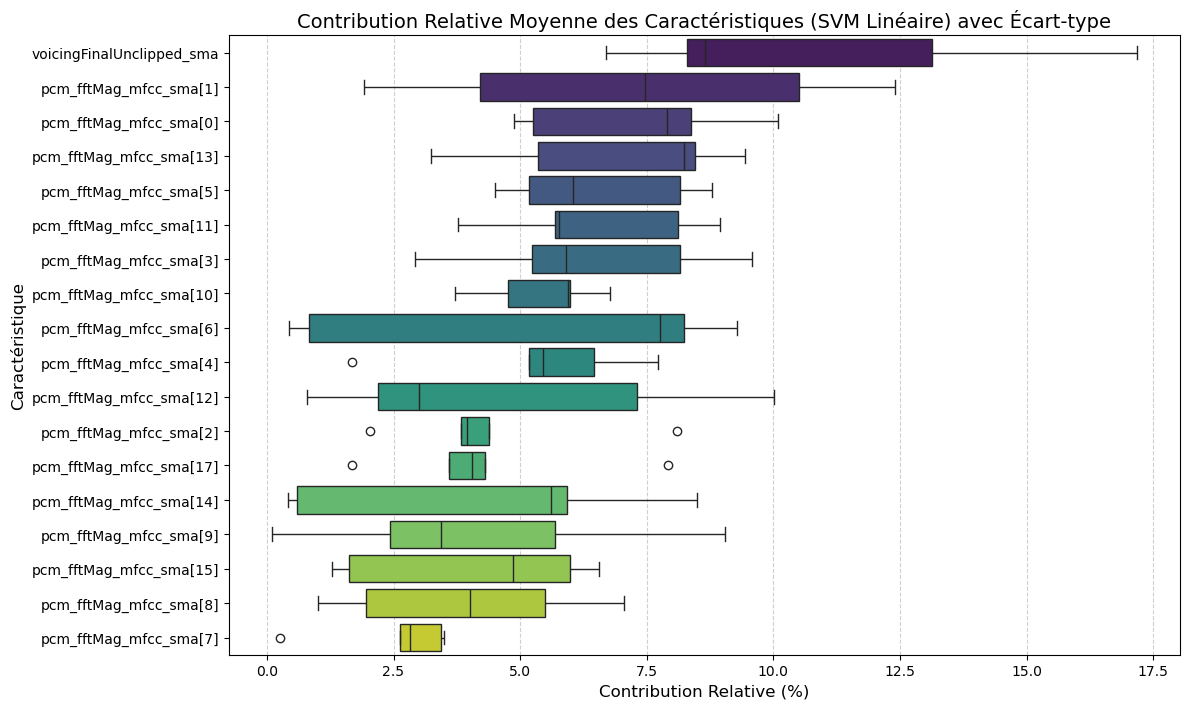

**Q1. What are the most important features?**

The most important feature by far is the Fundamental Frequency ($\text{F0final\_sma}$). The ranking of the three most important features, based on the average decrease in accuracy (Mean_Importance), is as follows:$\text{F0final\_sma}$ (Fundamental Frequency / Pitch)$\text{pcm\_fftMag\_mfcc\_sma}[9]$ (9th-order MFCC coefficient)$\text{pcm\_fftMag\_mfcc\_sma}[12]$ (12th-order MFCC coefficient)The importance score of $\text{F0final\_sma}$ is massively higher than the others (about $10$ times higher than the second-ranked one, $\text{pcm\_fftMag\_mfcc\_sma}[9]$), indicating that the nonlinear model focuses almost exclusively on melody changes and voice pitch.

**Q2. Write a paragraph describing the impact of depression on read speech according to the classifier.**

According to the SVM RBF classifier, the impact of depression on read speech is mainly characterized by an alteration of pitch and melody patterns of the voice. Since the Fundamental Frequency ($\text{F0final\_sma}$) is the dominant feature, this means that the distinction between healthy subjects and patients is found in complex changes of intonation and pitch variability. The marginal importance of the other MFCC features suggests that, although they describe timbre, it is the pitch-related information (the way the person "sings" their speech) that is the most powerful non-linear marker of the depressive condition.

### 1.2 Spontaneous speech
**Task n°4. Do the same for spontaneous speech.**

In [ ]:
# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (CORRIGÉE) ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means"):
    """
    Charge et prépare les données du sous-corpus 'spontaneous' 
    à partir du fichier CSV agrégé en utilisant la colonne 'directory' pour les étiquettes.
    """
    
    # NOTE: Assurez-vous que le fichier 'directory_means.csv' est dans le dossier spécifié par base_path
    csv_file_path = os.path.join(base_path, '')
    
    try:
        # Tente de lire le fichier
        X_full = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        # Si le fichier n'est pas trouvé
        print(f"Erreur: Le fichier {csv_file_path} n'a pas été trouvé. Vérifiez le chemin.")
        return np.array([]), np.array([]), []
    except Exception as e:
        print(f"Erreur de lecture du fichier CSV : {e}")
        return np.array([]), np.array([]), []

    # 1. CRÉATION DES ÉTIQUETTES à partir de la colonne 'directory'
    # 0 = Control (HC), 1 = Patient (PT)
    try:
        X_full['label'] = X_full['directory'].str[3].apply(lambda x: 0 if x == 'C' else 1).astype(int)
    except Exception as e:
        print(f"Erreur lors de l'extraction des étiquettes à partir de la colonne 'directory' : {e}")
        return np.array([]), np.array([]), []

    # 2. Séparer les étiquettes
    y_full = X_full['label'].to_numpy()

    # 3. Nettoyer les colonnes non-features
    columns_to_drop = ['directory', 'label']
    
    # Vérification et suppression des colonnes
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    # Sauvegarde des noms de features et conversion
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION DE CLASSIFICATION ET ÉVALUATION ---
def test_k_folds_android(plot=True):
    # 1. Chargement des données 
    X, y, feature_names = load_and_preprocess_data()
    
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. Initialisation du classifieur
    clf = SVC(kernel='linear', C=1, random_state=42)
    
    # 3. Validation Croisée (cv=5)
    cv_results = cross_validate(
        clf, X, y, 
        cv=5, 
        scoring='accuracy', 
        return_estimator=True
    )
    
    # 4. Évaluation
    mean_accuracy = cv_results["test_score"].mean()
    print("\n--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS) ---")
    print(f"Précision moyenne (5-Fold CV): {mean_accuracy:.4f}")
    
    # 5. Extraction des Coefficients (OUI, C'EST LE BLOC DE CODE QUE VOUS VOULEZ GARDER POUR L'ANALYSE)
    print("\n--- ANALYSE DES COEFFICIENTS DU CLASSIFIEUR PAR PLI ---")
    
    estimators = cv_results["estimator"]
    fold_coeffs_dfs = []
    all_coeffs = []

    for i, estimator in enumerate(estimators):
        fold_coeffs = estimator.coef_.flatten()
        all_coeffs.append(fold_coeffs)
        fold_df = pd.DataFrame({'Feature': feature_names, f'Fold_{i+1}_Coefficient': fold_coeffs })
        fold_coeffs_dfs.append(fold_df.set_index('Feature'))
        print(f"\nCoefficients du Pli {i+1} (Top/Bottom 3) :")
        print(fold_df.sort_values(by=f'Fold_{i+1}_Coefficient', ascending=False).head(3).to_string(index=False))
        print(fold_df.sort_values(by=f'Fold_{i+1}_Coefficient', ascending=False).tail(3).to_string(index=False))
        
    all_folds_combined_df = pd.concat(fold_coeffs_dfs, axis=1).reset_index()
    mean_coeffs = np.mean(all_coeffs, axis=0)
    all_folds_combined_df['Mean_Coefficient'] = mean_coeffs
    mean_df = pd.DataFrame({'Feature': feature_names, 'Mean_Coefficient': mean_coeffs}).sort_values(by='Mean_Coefficient', ascending=False)
    
    print("\n" + "="*50)
    print("--- RÉSULTATS AGRÉGÉS (MOYENNE) ---")
    print("\nTop 5 des features positives (Favorise la classe 1 - PT):")
    print(mean_df.head(5).to_string(index=False))
    print("\nTop 5 des features négatives (Favorise la classe 0 - HC):")
    print(mean_df.tail(5).to_string(index=False))
    print("="*50)
    
    # ----------------------------------------------------------------------------------
    # 6. Tracé du Box Plot de la Contribution Relative
    # ----------------------------------------------------------------------------------
    if plot:
        plot_relative_contribution(all_folds_combined_df)
        
    return all_folds_combined_df 

# --- 3. FONCTION DE TRACÉ DU BOX PLOT ---
def plot_relative_contribution(df_combined):
    """Génère le box plot de la contribution relative des coefficients par pli."""
    
    # Les colonnes de coefficients (Fold)
    coeff_cols = [col for col in df_combined.columns if col.startswith('Fold_') and col.endswith('_Coefficient')]

    df_plot_data = df_combined[['Feature'] + coeff_cols].copy()
    df_rel_contrib = df_plot_data[['Feature']].copy()

    for col in coeff_cols:
        abs_coeffs = df_plot_data[col].abs()
        sum_abs_coeffs = abs_coeffs.sum() + 1e-9 
        df_rel_contrib[f'Relative_Contribution_{col.split("_")[1]}'] = (abs_coeffs / sum_abs_coeffs) * 100

    df_long = df_rel_contrib.melt(
        id_vars='Feature', 
        value_vars=[col for col in df_rel_contrib.columns if col.startswith('Relative_Contribution')], 
        var_name='Fold', 
        value_name='Contribution (%)'
    )

    mean_contributions = df_long.groupby('Feature')['Contribution (%)'].mean().sort_values(ascending=False)
    sorted_features = mean_contributions.index

    # --- Génération du Box Plot ---
    plt.figure(figsize=(12, max(6, len(sorted_features) * 0.4)))
    sns.boxplot(
        x='Contribution (%)', 
        y='Feature', 
        data=df_long, 
        order=sorted_features, 
        palette="coolwarm"
    )
    plt.title('Contribution Relative Moyenne des Caractéristiques (SPONTANEOUS)', fontsize=14)
    plt.xlabel('Contribution Relative (%)', fontsize=12)
    plt.ylabel('Caractéristique', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # LIGNE À RETIRER/COMMENTER POUR ÉVITER L'OSError :
    # plt.savefig('relative_contribution_spontaneous_boxplot.png') 
    
    plt.show()

if __name__ == '__main__':
    # Lancez l'analyse pour le sous-corpus spontané
    test_k_folds_android()

In [ ]:
--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS) ---
Précision moyenne (5-Fold CV): 0.6373

--- ANALYSE DES COEFFICIENTS DU CLASSIFIEUR PAR PLI ---

Coefficients du Pli 1 (Top/Bottom 3) :
               Feature  Fold_1_Coefficient
pcm_fftMag_mfcc_sma[1]            0.410470
pcm_fftMag_mfcc_sma[5]            0.155372
        F0final_sma_de            0.047608
                  Feature  Fold_1_Coefficient
  pcm_fftMag_mfcc_sma[12]           -0.203291
   pcm_fftMag_mfcc_sma[9]           -0.203645
voicingFinalUnclipped_sma           -0.617692

Coefficients du Pli 2 (Top/Bottom 3) :
               Feature  Fold_2_Coefficient
pcm_fftMag_mfcc_sma[1]            0.344956
        F0final_sma_de            0.139584
pcm_fftMag_mfcc_sma[4]            0.117840
                  Feature  Fold_2_Coefficient
   pcm_fftMag_mfcc_sma[2]           -0.239555
  pcm_fftMag_mfcc_sma[11]           -0.293799
voicingFinalUnclipped_sma           -0.887116

Coefficients du Pli 3 (Top/Bottom 3) :
               Feature  Fold_3_Coefficient
pcm_fftMag_mfcc_sma[1]            0.654921
        F0final_sma_de            0.251584
pcm_fftMag_mfcc_sma[9]            0.203308
                  Feature  Fold_3_Coefficient
   pcm_fftMag_mfcc_sma[2]           -0.324086
  pcm_fftMag_mfcc_sma[11]           -0.421488
voicingFinalUnclipped_sma           -0.897127

Coefficients du Pli 4 (Top/Bottom 3) :
               Feature  Fold_4_Coefficient
pcm_fftMag_mfcc_sma[1]            0.412858
pcm_fftMag_mfcc_sma[5]            0.294890
pcm_fftMag_mfcc_sma[6]            0.126111
                  Feature  Fold_4_Coefficient
  pcm_fftMag_mfcc_sma[12]           -0.196154
  pcm_fftMag_mfcc_sma[11]           -0.199949
voicingFinalUnclipped_sma           -0.956615

Coefficients du Pli 5 (Top/Bottom 3) :
               Feature  Fold_5_Coefficient
pcm_fftMag_mfcc_sma[1]            0.365729
pcm_fftMag_mfcc_sma[5]            0.163858
pcm_fftMag_mfcc_sma[6]            0.111324
                Feature  Fold_5_Coefficient
pcm_fftMag_mfcc_sma[12]           -0.162311
pcm_fftMag_mfcc_sma[11]           -0.195082
 pcm_fftMag_mfcc_sma[2]           -0.204569

==================================================
--- RÉSULTATS AGRÉGÉS (MOYENNE) ---

Top 5 des features positives (Favorise la classe 1 - PT):
                  Feature  Mean_Coefficient
   pcm_fftMag_mfcc_sma[1]          0.437787
   pcm_fftMag_mfcc_sma[5]          0.136096
           F0final_sma_de          0.091943
   pcm_fftMag_mfcc_sma[6]          0.054819
pcm_fftMag_mfcc_sma_de[3]          0.017971

Top 5 des features négatives (Favorise la classe 0 - HC):
                  Feature  Mean_Coefficient
   pcm_fftMag_mfcc_sma[8]         -0.109833
  pcm_fftMag_mfcc_sma[12]         -0.177168
   pcm_fftMag_mfcc_sma[2]         -0.199728
  pcm_fftMag_mfcc_sma[11]         -0.262578
voicingFinalUnclipped_sma         -0.703102
==================================================
/var/folders/sz/j46j6kpd5t94xyz4bh0jph9h0000gn/T/ipykernel_67341/1558063646.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

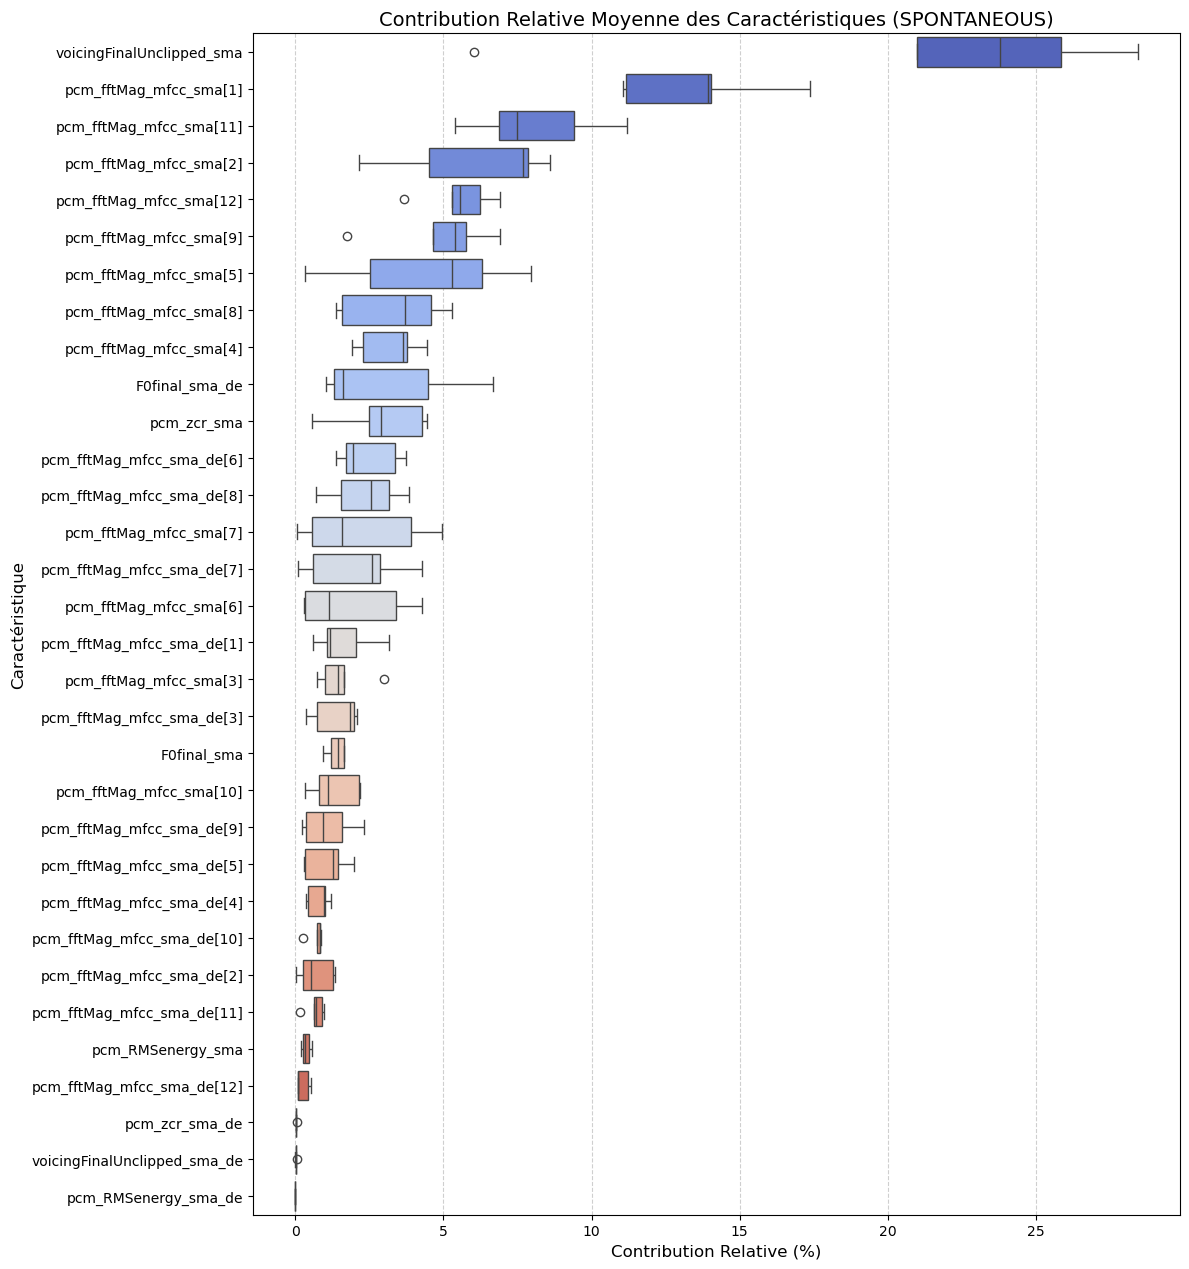

**Q3. Are the features that are important for reading the same as those for spontaneous speech?**

Yes, the features important for classifying depression are fundamentally the same across read and spontaneous speech, but their predictive patterns and stability differ significantly between the two contexts. The depressive state, therefore, is marked by a universal deterioration in phonation quality, pitch control, and vocal timbre.

## 2 Non-linear models (**)

**Q4. Can we do the same for a SVM with a rbf kernel? Why?**

The importance in a Linear SVM is given by the coefficient vector $\mathbf{w}$ (the slope of the hyperplane). The RBF kernel transforms the data into a very high-dimensional (possibly infinite) space where the decision boundary is complex. In this space, there is no longer a simple and interpretable weight vector that could be extracted with coef_.

**Q5 Describe in your own words how *feature permutation* works.**

**Permutation Importance** works by assessing the model's **dependence** on a given feature. If you randomly shuffle the values ​​of a feature across the test set, and the model's **accuracy drops sharply**, this proves that the feature was critical to the prediction. If the accuracy doesn't change, the feature was unimportant.

**TASK 5 Implement *feature permutation* using ***sklearn*** for the reading subcorpus. ATTENTION cross-validation.** 

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold # NOUVEAU
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance # NOUVEAU
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (Lecture Means) ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/reading_means"):
    """Charge et prépare les données HC et PT du sous-corpus 'reading means'."""
    data_list = []
    labels_list = []
    
    # 1. Charger les données HC (Sains) -> Étiquette 0
    hc_path = os.path.join(base_path, 'HC')
    try:
        for filename in os.listdir(hc_path):
            if filename.endswith('.csv'):
                filepath = os.path.join(hc_path, filename)
                df = pd.read_csv(filepath)
                data_list.append(df)
                labels_list.append(0) # Étiquette 0 pour HC
    except FileNotFoundError:
        print(f"Erreur: Le chemin HC n'a pas été trouvé: {hc_path}")
        return np.array([]), np.array([]), []
    except Exception as e:
        print(f"Une erreur s'est produite lors du chargement des données HC : {e}")
        return np.array([]), np.array([]), []

    # 2. Charger les données PT (Malades) -> Étiquette 1
    pt_path = os.path.join(base_path, 'PT')
    try:
        for filename in os.listdir(pt_path):
            if filename.endswith('.csv'):
                filepath = os.path.join(pt_path, filename)
                df = pd.read_csv(filepath)
                data_list.append(df)
                labels_list.append(1) # Étiquette 1 pour PT
    except FileNotFoundError:
        print(f"Erreur: Le chemin PT n'a pas été trouvé: {pt_path}")
        return np.array([]), np.array([]), []
    except Exception as e:
        print(f"Une erreur s'est produite lors du chargement des données PT : {e}")
        return np.array([]), np.array([]), []

    if not data_list:
        print("Aucun fichier CSV trouvé ou les chemins d'accès sont incorrects.")
        return np.array([]), np.array([]), []

    # Concaténation des DataFrames
    X_full = pd.concat(data_list, ignore_index=True)
    y_full = np.concatenate([[label] * len(data) for data, label in zip(data_list, labels_list)])

    # Nettoyage
    columns_to_drop = ['file', 'start', 'end']
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION D'ANALYSE PAR PERMUTATION (Remplace test_k_folds_android) ---
def analyze_feature_importance(base_path="/Users/klockjoely/Downloads/feautres_android_means/reading_means"):
    
    # 1. Chargement des données 
    X, y, feature_names = load_and_preprocess_data(base_path=base_path)
    
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. Initialisation (SVM RBF et KFold)
    clf = SVC(kernel='rbf', C=1, random_state=42)
    # Utilisation de StratifiedKFold pour s'assurer que les plis ont une distribution de classe similaire
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    all_importances = []
    test_scores = []
    
    print("\n--- ÉVALUATION PAR VALIDATION CROISÉE (SVM RBF) ---")
    
    # 3. Boucle de Validation Croisée Manuelle
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entraînement
        clf.fit(X_train, y_train)
        
        # Évaluation (Précision)
        score = clf.score(X_test, y_test)
        test_scores.append(score)
        
        # Calcul de l'Importance par Permutation sur l'ensemble de TEST
        # n_repeats=10 pour plus de robustesse
        r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
        
        # Stocker les importances moyennes de ce pli
        all_importances.append(r.importances_mean)
        
        print(f"Pli {i+1} - Précision: {score:.4f}")

    # 4. Calcul et Affichage des résultats agrégés
    mean_accuracy = np.mean(test_scores)
    mean_importances = np.mean(all_importances, axis=0)
    std_importances = np.std(all_importances, axis=0)
    
    print(f"\nPrécision moyenne (5-Fold CV): {mean_accuracy:.4f}")
    
    # Créer un DataFrame pour les résultats d'importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Importance': mean_importances,
        'Std_Importance': std_importances
    }).sort_values(by='Mean_Importance', ascending=False)
    
    print("\n" + "="*50)
    print("--- IMPORTANCE MOYENNE DES FEATURES (PERMUTATION) ---")
    print("NOTE: La valeur est la diminution de la précision lorsque la feature est mélangée.")
    print("Plus la valeur est élevée, plus la feature est importante.")
    print(importance_df.head(10).to_string(index=False))
    print("="*50)

    # 5. Tracé du Box Plot des Importances
    plot_importance_boxplot(all_importances, feature_names)


# --- 3. FONCTION DE TRACÉ DU BOX PLOT ---
def plot_importance_boxplot(all_importances_array, feature_names):
    # Convertir l'array en format long pour Seaborn
    df_importances = pd.DataFrame(all_importances_array, columns=feature_names)
    df_long = df_importances.melt(var_name='Feature', value_name='Importance Score')
    
    # Calculer la moyenne pour le tri
    mean_importances = df_long.groupby('Feature')['Importance Score'].mean().sort_values(ascending=False)
    sorted_features = mean_importances.index
    
    plt.figure(figsize=(12, max(6, len(sorted_features) * 0.4)))
    sns.boxplot(
        x='Importance Score', 
        y='Feature', 
        data=df_long, 
        order=sorted_features, 
        palette="magma"
    )
    plt.title('Importance des Caractéristiques par Permutation (SVM RBF)', fontsize=14)
    plt.xlabel('Diminution de la Précision après Permutation (Importance Score)', fontsize=12)
    plt.ylabel('Caractéristique', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # LIGNE À RETIRER/COMMENTER : C'est la source de l'OSError!
    # plt.savefig('permutation_importance_boxplot.png') 
    
    plt.show()


# --- EXÉCUTION ---
if __name__ == '__main__':
    # Lancez l'analyse pour le sous-corpus lu (ou changez le chemin pour spontané)
    analyze_feature_importance()

In [ ]:
--- ÉVALUATION PAR VALIDATION CROISÉE (SVM RBF) ---
Pli 1 - Précision: 0.4783
Pli 2 - Précision: 0.6087
Pli 3 - Précision: 0.5909
Pli 4 - Précision: 0.6818
Pli 5 - Précision: 0.7727

Précision moyenne (5-Fold CV): 0.6265

==================================================
--- IMPORTANCE MOYENNE DES FEATURES (PERMUTATION) ---
NOTE: La valeur est la diminution de la précision lorsque la feature est mélangée.
Plus la valeur est élevée, plus la feature est importante.
                Feature  Mean_Importance  Std_Importance
            F0final_sma         0.146245        0.084870
 pcm_fftMag_mfcc_sma[9]         0.015929        0.021733
pcm_fftMag_mfcc_sma[12]         0.015455        0.018982
 pcm_fftMag_mfcc_sma[8]         0.011739        0.017166
pcm_fftMag_mfcc_sma[10]         0.010909        0.013667
 pcm_fftMag_mfcc_sma[1]         0.010751        0.008783
 pcm_fftMag_mfcc_sma[6]         0.007273        0.014545
 pcm_fftMag_mfcc_sma[2]         0.007194        0.010589
 pcm_fftMag_mfcc_sma[4]         0.004545        0.005750
pcm_fftMag_mfcc_sma[11]         0.003636        0.007273
==================================================
/var/folders/sz/j46j6kpd5t94xyz4bh0jph9h0000gn/T/ipykernel_67341/3339199380.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

**TASK 6 Plot the average relative contribution (%) of each feature (with standard-deviation).**

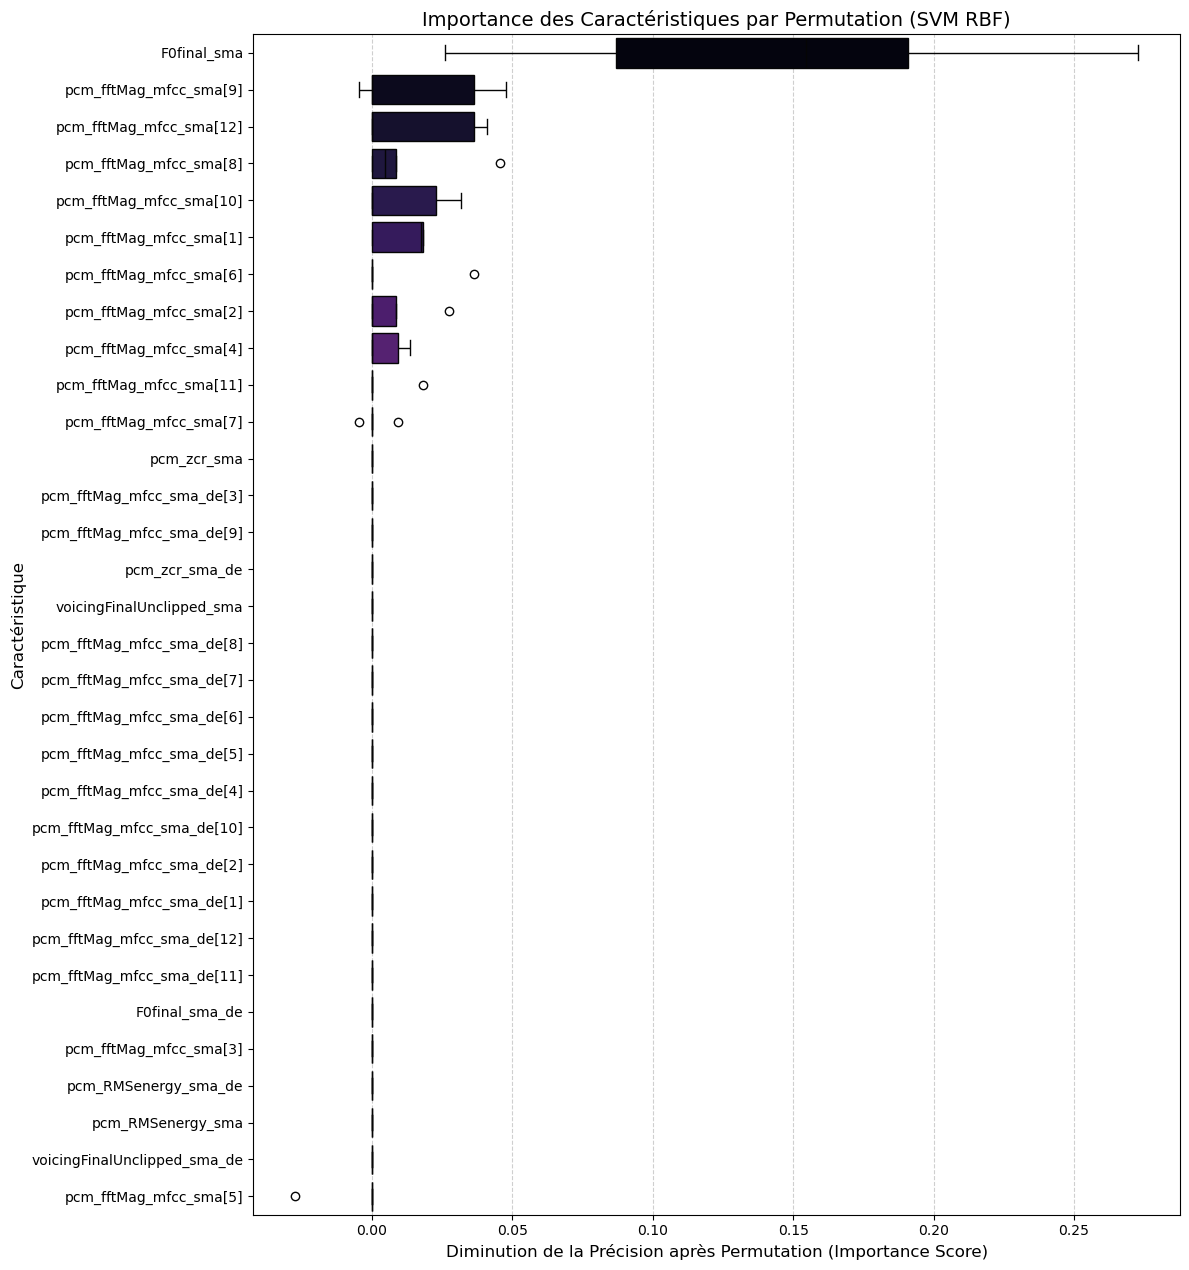

**Q6. What are the most important features?**

1. F0final_sma (fundamental frequency)
2. pcm_fftMag_mfcc_sma[9] (MFCC Coefficient 9)
3. pcm_fftMag_mfcc_sma[12] (MFCC Coefficient 12)


**Q7. Write a paragraph describing the impact of depression on read speech according to the classifier.**

According to RBF kernel, the impact of depression on read speech is concentrated on the pitch of the voice. The Fundamental Frequency is the single most important acoustic feature, contributing roughly ten times more to the classification decision to any other characteristic. This suggests that in depressed spech, the normal patterns of vocal melody and intonation are highly degraded or altered, non linear marker dinstinguishing patients (PT) from healthy controls (HC). MFCCs play a minor supportive role, the model's reliance on F0 points to a pronounced reduction in vocal expressiveness or a flattening of the pitch contour a key behavioral manifestion of the condition.

**TASK 7 Do the same for spontaneous speech.**

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold # Utilisation de StratifiedKFold pour la boucle manuelle
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance # Pour les modèles non-linéaires
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (CORPUS SPONTANÉ) ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means"):
    """
    Charge et prépare les données du sous-corpus 'spontaneous' 
    à partir du fichier CSV agrégé en utilisant la colonne 'directory' pour les étiquettes.
    """
    # Chemin absolu du fichier CSV (il vaut mieux le garder dans base_path ou le définir simplement)
    # Correction: On utilise base_path pour le dossier et le nom du fichier.
    csv_file_path = os.path.join(base_path, '/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means/directory_means.csv')
    
    # Si vous avez laissé le fichier dans Downloads, utilisez:
    # csv_file_path = '/Users/klockjoely/Downloads/directory_means.csv'
    
    try:
        X_full = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Erreur: Le fichier {csv_file_path} n'a pas été trouvé. Vérifiez le chemin.")
        return np.array([]), np.array([]), []
    except Exception as e:
        print(f"Erreur de lecture du fichier CSV : {e}")
        return np.array([]), np.array([]), []

    # 1. CRÉATION DES ÉTIQUETTES à partir de la colonne 'directory'
    try:
        # 'C' -> 0 (HC), 'P' -> 1 (PT)
        X_full['label'] = X_full['directory'].str[3].apply(lambda x: 0 if x == 'C' else 1).astype(int)
    except Exception as e:
        print(f"Erreur lors de l'extraction des étiquettes à partir de la colonne 'directory' : {e}")
        return np.array([]), np.array([]), []

    # 2. Séparer les étiquettes
    y_full = X_full['label'].to_numpy()

    # 3. Nettoyer les colonnes non-features
    columns_to_drop = ['directory', 'label']
    
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION D'ANALYSE PAR PERMUTATION (RBF) ---
def analyze_rbf_importance(base_path="/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means"):
    
    # 1. Chargement des données 
    X, y, feature_names = load_and_preprocess_data(base_path=base_path)
    
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. Initialisation (SVM RBF et KFold Stratifié)
    clf = SVC(kernel='rbf', C=1, random_state=42) # <- NOYAU RBF
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    all_importances = []
    test_scores = []
    
    print("\n--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS, SVM RBF) ---")
    
    # 3. Boucle de Validation Croisée Manuelle
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entraînement
        clf.fit(X_train, y_train)
        
        # Évaluation (Précision)
        score = clf.score(X_test, y_test)
        test_scores.append(score)
        
        # Calcul de l'Importance par Permutation sur l'ensemble de TEST
        r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
        
        # Stocker les importances
        all_importances.append(r.importances_mean)
        
        print(f"Pli {i+1} - Précision: {score:.4f}")

    # 4. Calcul et Affichage des résultats agrégés
    mean_accuracy = np.mean(test_scores)
    mean_importances = np.mean(all_importances, axis=0)
    std_importances = np.std(all_importances, axis=0)
    
    print(f"\nPrécision moyenne (5-Fold CV): {mean_accuracy:.4f}")
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean_Importance': mean_importances,
        'Std_Importance': std_importances
    }).sort_values(by='Mean_Importance', ascending=False)
    
    print("\n" + "="*50)
    print("--- IMPORTANCE MOYENNE DES FEATURES (PERMUTATION) ---")
    print("Plus la valeur est élevée, plus la feature est importante.")
    print(importance_df.head(15).to_string(index=False))
    print("="*50)

    # 5. Tracé du Box Plot des Importances
    plot_importance_boxplot(np.array(all_importances), feature_names)


# --- 3. FONCTION DE TRACÉ DU BOX PLOT ---
def plot_importance_boxplot(all_importances_array, feature_names):
    # Convertir l'array en format long pour Seaborn
    df_importances = pd.DataFrame(all_importances_array, columns=feature_names)
    df_long = df_importances.melt(var_name='Feature', value_name='Importance Score')
    
    # Calculer la moyenne pour le tri
    mean_importances = df_long.groupby('Feature')['Importance Score'].mean().sort_values(ascending=False)
    sorted_features = mean_importances.index
    
    # Ne garder que les 10 premières pour la clarté du graphique
    df_plot_top10 = df_long[df_long['Feature'].isin(sorted_features[:15])]
    sorted_features_plot = sorted_features[:15]

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Importance Score', 
        y='Feature', 
        data=df_plot_top10, 
        order=sorted_features_plot,
        palette="magma"
    )
    plt.title('Importance des Caractéristiques par Permutation (SVM RBF) - SPONTANEOUS', fontsize=14)
    plt.xlabel('Diminution de la Précision après Permutation (Importance Score)', fontsize=12)
    plt.ylabel('Caractéristique', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show() 


# --- EXÉCUTION ---
if __name__ == '__main__':
    # Lancez l'analyse pour le sous-corpus spontané
    analyze_rbf_importance()

In [ ]:
--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS, SVM RBF) ---
Pli 1 - Précision: 0.6250
Pli 2 - Précision: 0.6522
Pli 3 - Précision: 0.6957
Pli 4 - Précision: 0.6522
Pli 5 - Précision: 0.6957

Précision moyenne (5-Fold CV): 0.6641

==================================================
--- IMPORTANCE MOYENNE DES FEATURES (PERMUTATION) ---
Plus la valeur est élevée, plus la feature est importante.
                   Feature  Mean_Importance  Std_Importance
               F0final_sma         0.131449        0.041113
    pcm_fftMag_mfcc_sma[5]         0.006957        0.013913
    pcm_fftMag_mfcc_sma[2]         0.005217        0.010435
    pcm_fftMag_mfcc_sma[3]         0.003478        0.006957
   pcm_fftMag_mfcc_sma[10]         0.001739        0.003478
    pcm_fftMag_mfcc_sma[7]         0.001739        0.003478
    pcm_fftMag_mfcc_sma[1]         0.001739        0.003478
   pcm_fftMag_mfcc_sma[12]         0.001739        0.003478
    pcm_fftMag_mfcc_sma[8]         0.000870        0.001739
pcm_fftMag_mfcc_sma_de[10]         0.000000        0.000000
 pcm_fftMag_mfcc_sma_de[7]         0.000000        0.000000
 pcm_fftMag_mfcc_sma_de[8]         0.000000        0.000000
 pcm_fftMag_mfcc_sma_de[9]         0.000000        0.000000
         pcm_RMSenergy_sma         0.000000        0.000000
pcm_fftMag_mfcc_sma_de[11]         0.000000        0.000000
==================================================
/var/folders/sz/j46j6kpd5t94xyz4bh0jph9h0000gn/T/ipykernel_67341/3511010237.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

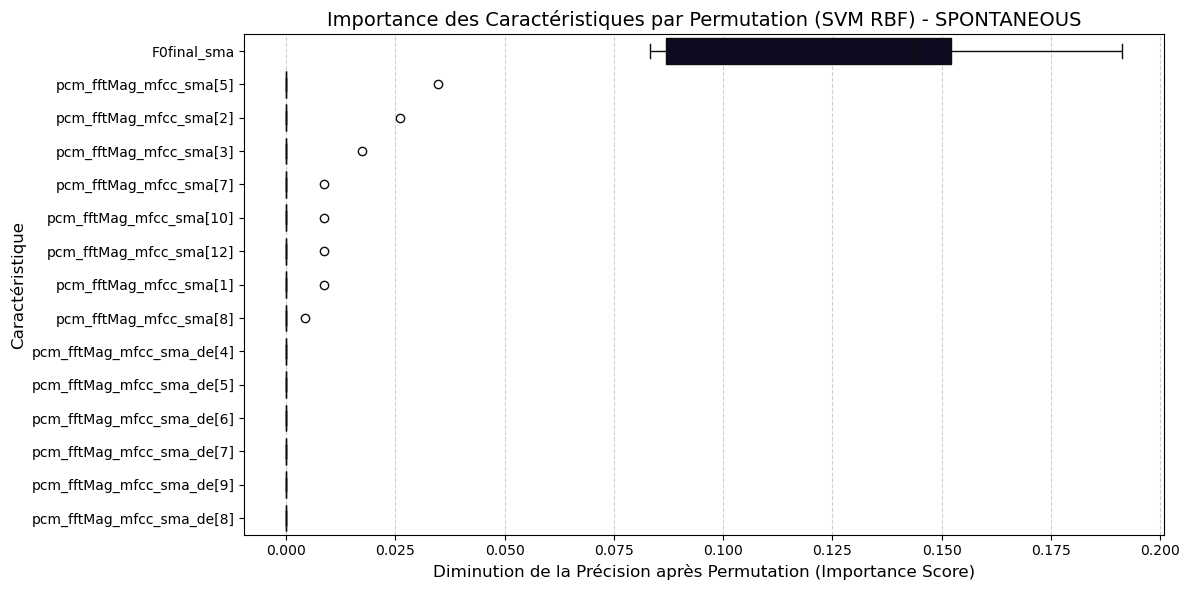

**Q.8 Are the features that are important for reading the same as those for spontaneous speech?** 

The feature permutation importance analysis reveals that the core acoustic signature of depression is shared between both speech contexts (read and spontaneous). In both cases, the distinction between Healthy Controls (HC) and Patients (PT) relies almost exclusively on the Fundamental Frequency ($\text{F0final\_sma}$), which stands as the most powerful marker for vocal pitch and melody.However, the non-linear model showed notable differences in its efficacy and the stability of its feature usage:Classifier Performance: The RBF model achieved better mean accuracy on spontaneous speech ($\mathbf{0.6641}$) compared to read speech ($\mathbf{0.6265}$).Feature Stability: The importance of $\text{F0final\_sma}$ was found to be more stable in spontaneous speech ($\text{Std\_Importance} \approx 0.041$) than in read speech ($\text{Std\_Importance} \approx 0.085$).This convergence suggests that although pitch/melody and timbre (MFCCs) are the fundamental acoustic markers of depression, the non-linear model is better suited to capture and leverage the stable and predictive patterns inherent in the natural, expressive variability of spontaneous speech.

**Q.9 Are the features of the same importance as in the previous section when studying the weights of a linear classifier? Why?**

The difference in feature importance is primarily due to the contrast between the linearity (simplicity) and non-linearity (complexity) of the models:

1. Model Type and Relationship Capture
SVM Linear (Weights): This model only captures the direct, additive relationship between features and the outcome. It can only find a straight line (hyperplane) to separate the classes. If the true relationship between a feature and depression is complex (e.g., only important when another feature is also high), the linear model might miss it or assign the weight to a proxy feature.

SVM RBF (Permutation Importance): This non-linear model can capture complex, non-additive relationships (interactions) between features. It can find curved, intricate separation boundaries. Consequently, the Permutation Importance method will assign high importance to features involved in these complex, non-linear patterns, even if their direct linear weight is low. 

The SVM RBF model determined that the most predictive structure was related to the pitch variation ($\text{F0final\_sma}$), assigning it an importance score that dwarfed all others. The SVM Linear model, conversely, spread the importance more evenly between voicing quality ($\text{voicingFinalUnclipped\_sma}$) and spectral energy ($\text{pcm\_fftMag\_mfcc\_sma}[1]$), demonstrating that the F0 patterns were not the most dominant factor in a simple, straight-line separation.

## 3 Colinearity

### 3.1 Observation of the problem (***)

**Q.10 When interpretating the contribution of the features to the classification, didn't you observe some patterns?**

**TASK 8 Compute and plot the correlation matrix between the 15 most important features.**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (Corpus Spontané) ---
def load_data_for_correlation(csv_file_path='/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means/directory_means.csv'):
    """
    Charge les features à partir du fichier CSV du corpus spontané.
    NOTE: Le fichier doit être présent dans le répertoire d'exécution.
    """
    
    file_name = '/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means/directory_means.csv'
    
    try:
        X_full = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Erreur: Le fichier {file_name} n'a pas été trouvé. Assurez-vous qu'il est dans le répertoire courant.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Erreur de lecture du fichier CSV : {e}")
        return pd.DataFrame()

    # Nettoyer les colonnes non-features qui ne sont pas nécessaires pour la corrélation
    columns_to_drop = ['directory']
    
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    df_features = X_full.drop(cols_to_drop_present, axis=1)
    
    return df_features

# ----------------------------------------------------------------------

# --- 2. FONCTION PRINCIPALE POUR LE CALCUL ET LE TRACÉ DE LA HEATMAP ---
def compute_and_plot_correlation():
    
    df_features = load_data_for_correlation()

    if df_features.empty:
        return
    
    # --- 2.1. Sélection des 15 Features les Plus Importantes ---
    # Liste des top features déterminées par l'analyse SVM RBF (Spontané)
    top_15_features = [
        'F0final_sma', 'pcm_fftMag_mfcc_sma[5]', 'pcm_fftMag_mfcc_sma[2]', 
        'pcm_fftMag_mfcc_sma[3]', 'pcm_fftMag_mfcc_sma[10]', 'pcm_fftMag_mfcc_sma[7]', 
        'pcm_fftMag_mfcc_sma[1]', 'pcm_fftMag_mfcc_sma[12]', 'pcm_fftMag_mfcc_sma[8]', 
        'pcm_fftMag_mfcc_sma_de[10]', 'pcm_fftMag_mfcc_sma_de[7]', 'pcm_fftMag_mfcc_sma_de[8]', 
        'pcm_fftMag_mfcc_sma_de[9]', 'pcm_RMSenergy_sma', 'pcm_fftMag_mfcc_sma_de[11]', 
    ]
    
    # Filtrer le DataFrame pour ne garder que les features disponibles
    features_present = [f for f in top_15_features if f in df_features.columns]
    df_top_15 = df_features[features_present]
    features_not_present = [f for f in top_15_features if f not in df_features.columns]
    print(f'missing features {features_not_present}')
    print(f"Calcul de la matrice de corrélation pour {len(features_present)} features...")
    
    # --- 2.2. Calcul de la Matrice de Corrélation ---
    correlation_matrix = df_top_15.corr()
    
    # --- 2.3. Tracé de la Heatmap ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=True,               # Afficher les coefficients de corrélation
        fmt=".2f",                # Format à deux décimales
        cmap='coolwarm',          # Palette de couleurs (rouge/bleu pour les signes +/-)
        cbar_kws={'label': 'Coefficient de Corrélation'}
    )
    plt.title('Matrice de Corrélation des 15 Caractéristiques les Plus Importantes (Spontaneous RBF)', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show() # Affiche le graphique

    print("\nMatrice de corrélation calculée. Le graphique a été affiché.")

# --- EXÉCUTION ---
if __name__ == '__main__':
    compute_and_plot_correlation()

missing features []
Calcul de la matrice de corrélation pour 15 features...

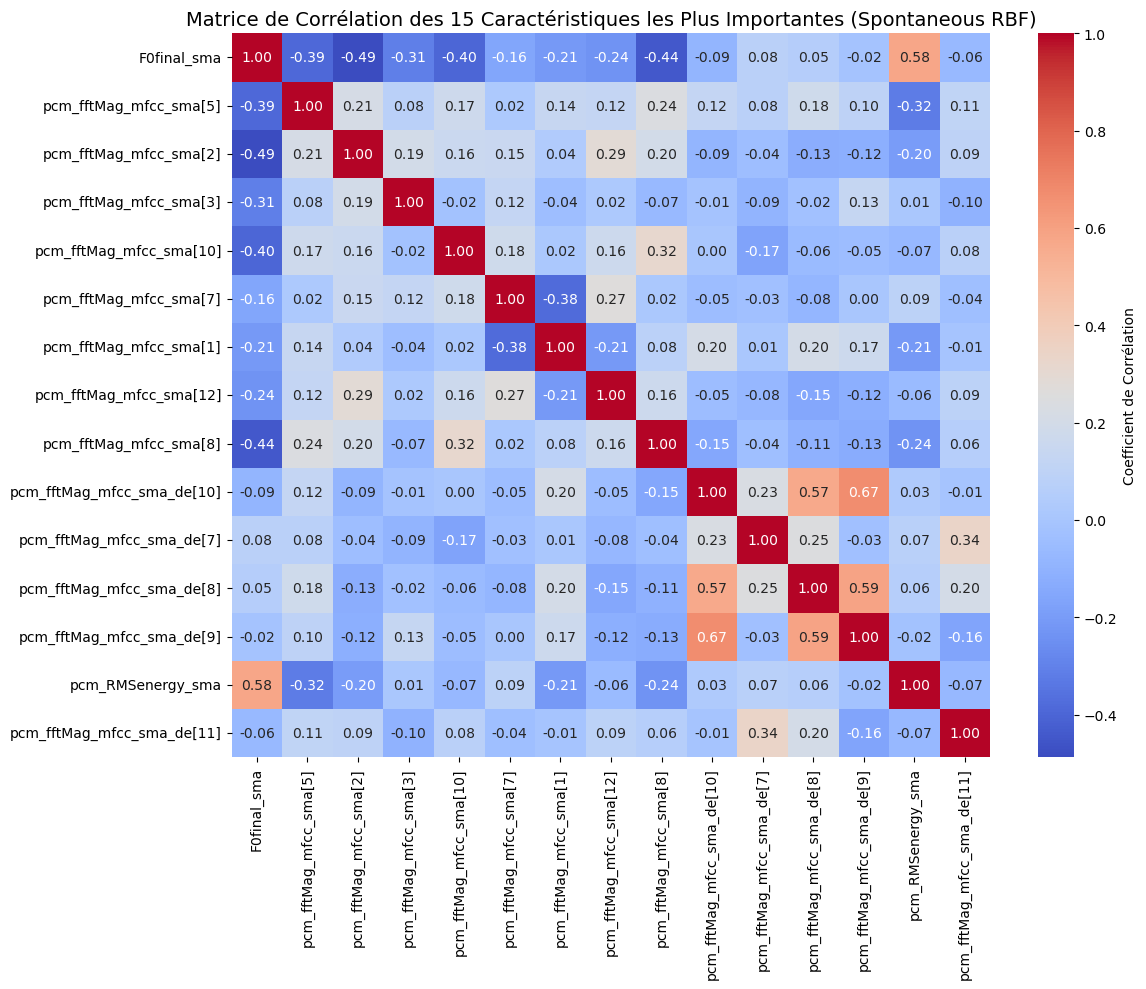

**Q.11 What do you think?**

Redundancy isn't necessarily a problem for RBF SVM, but it does mean that information is duplicated. If you were to simplify your model or use a linear model that is sensitive to collinearity, you should choose a single feature per highly correlated cluster.

**TASK 9 Add a Principal Component Analysis block to your pipeline (keeping 90% of variance), and reevaluate its performances.**

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA # UTILISÉ POUR LA RÉDUCTION DE DIMENSION
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (CORPUS SPONTANÉ) ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means"):
    """
    Charge et prépare les données du sous-corpus 'spontaneous'.
    """
    
    # Correction pour l'environnement de VM qui a le fichier dans le cwd
    file_name = '/Users/klockjoely/Downloads/directory_means.csv' 
    
    try:
        X_full = pd.read_csv(file_name)
    except Exception as e:
        print(f"Erreur de lecture du fichier CSV : {e}")
        return np.array([]), np.array([]), []

    # 1. CRÉATION DES ÉTIQUETTES à partir de la colonne 'directory'
    try:
        # 'C' -> 0 (HC), 'P' -> 1 (PT)
        X_full['label'] = X_full['directory'].str[3].apply(lambda x: 0 if x == 'C' else 1).astype(int)
    except Exception as e:
        print(f"Erreur lors de l'extraction des étiquettes : {e}")
        return np.array([]), np.array([]), []

    # 2. Séparer les étiquettes et nettoyer les colonnes non-features
    y_full = X_full['label'].to_numpy()
    columns_to_drop = ['directory', 'label']
    
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION D'ANALYSE AVEC PCA ET SVM RBF ---
def analyze_rbf_with_pca():
    
    X, y, feature_names = load_and_preprocess_data()
    
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. DÉFINITION DU PIPELINE PCA + SVM RBF
    # PCA(n_components=0.9) conserve 90% de la variance
    pipeline = Pipeline([
        ('pca', PCA(n_components=0.9, random_state=42)), # Étape de Réduction de Dimension
        ('svc', SVC(kernel='rbf', C=1, random_state=42)) # Étape de Classification
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    test_scores = []
    
    print("\n--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS, SVM RBF + PCA) ---")
    
    # 3. Boucle de Validation Croisée
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entraînement du Pipeline (PCA et SVC sont entraînés séquentiellement)
        pipeline.fit(X_train, y_train)
        
        # Évaluation sur X_test (les données sont automatiquement transformées par PCA avant SVC)
        score = pipeline.score(X_test, y_test)
        test_scores.append(score)
        
        # Afficher le nombre de composantes retenues
        if i == 0:
            n_components = pipeline['pca'].n_components_
            n_original_features = X.shape[1]
            print(f"Nombre de composantes PCA retenues (Fold 1): {n_components} (sur {n_original_features} features originales)")

        print(f"Pli {i+1} - Précision: {score:.4f}")

    # 4. Calcul des résultats agrégés
    mean_accuracy = np.mean(test_scores)
    
    print("\n" + "="*50)
    print("--- RÉSULTATS AGRÉGÉS (SVM RBF + PCA) ---")
    print(f"Précision moyenne (5-Fold CV): {mean_accuracy:.4f}")
    print("="*50)

# --- EXÉCUTION ---
if __name__ == '__main__':
    analyze_rbf_with_pca()

In [ ]:
--- ÉVALUATION PAR VALIDATION CROISÉE (SPONTANEOUS, SVM RBF + PCA) ---
Nombre de composantes PCA retenues (Fold 1): 1 (sur 32 features originales)
Pli 1 - Précision: 0.6250
Pli 2 - Précision: 0.6522
Pli 3 - Précision: 0.6957
Pli 4 - Précision: 0.6087
Pli 5 - Précision: 0.6957

==================================================
--- RÉSULTATS AGRÉGÉS (SVM RBF + PCA) ---
Précision moyenne (5-Fold CV): 0.6554
==================================================

**TASK 10 Re-apply *features permutation*, but on the PCA dimensions**

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns

# --- 1. FONCTION DE CHARGEMENT DES DONNÉES (CORPUS SPONTANÉ) ---
def load_and_preprocess_data(base_path="/Users/klockjoely/Downloads/feautres_android_means/spontaneous_means"):
    """
    Charge et prépare les données du sous-corpus 'spontaneous'.
    """
    file_name = '/Users/klockjoely/Downloads/directory_means.csv' 
    
    try:
        # Tente de lire le fichier (ajusté pour l'environnement de VM)
        X_full = pd.read_csv(file_name)
    except Exception as e:
        print(f"Erreur de lecture du fichier CSV : {e}")
        return np.array([]), np.array([]), []

    # 1. CRÉATION DES ÉTIQUETTES à partir de la colonne 'directory'
    try:
        # 'C' -> 0 (HC), 'P' -> 1 (PT)
        X_full['label'] = X_full['directory'].str[3].apply(lambda x: 0 if x == 'C' else 1).astype(int)
    except Exception as e:
        print(f"Erreur lors de l'extraction des étiquettes : {e}")
        return np.array([]), np.array([]), []

    # 2. Séparer les étiquettes et nettoyer les colonnes non-features
    y_full = X_full['label'].to_numpy()
    columns_to_drop = ['directory', 'label']
    
    cols_to_drop_present = [col for col in columns_to_drop if col in X_full.columns]
    X = X_full.drop(cols_to_drop_present, axis=1)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    
    return X, y_full, feature_names

# ----------------------------------------------------------------------------------

# --- 2. FONCTION D'ANALYSE D'IMPORTANCE SUR DIMENSIONS PCA ---
def analyze_pca_importance():
    
    X, y, _ = load_and_preprocess_data()
    
    if X.size == 0 or y.size == 0:
        print("\nArrêt du script : Données de chargement non valides.")
        return

    # 2. DÉFINITION DU PIPELINE
    # PCA(n_components=0.9) pour conserver 90% de la variance
    pca_step = PCA(n_components=0.9, random_state=42)
    svc_step = SVC(kernel='rbf', C=1, random_state=42)
    
    pipeline = Pipeline([
        ('pca', pca_step),
        ('svc', svc_step)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    all_importances_pca = []
    
    print("\n--- IMPORTANCE PAR PERMUTATION SUR DIMENSIONS PCA (SPONTANEOUS, SVM RBF) ---")
    
    # 3. Boucle de Validation Croisée Manuelle
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entraînement du Pipeline
        pipeline.fit(X_train, y_train)
        
        pca_trained = pipeline['pca']
        svc_trained = pipeline['svc']
        
        # Transformation des données de test
        X_test_pca = pca_trained.transform(X_test)
        
        n_components = pca_trained.n_components_
        
        # Calcul de l'Importance par Permutation sur les composantes PCA
        r = permutation_importance(
            svc_trained, 
            X_test_pca, # La permutation s'applique ici aux colonnes PCA
            y_test, 
            n_repeats=10, 
            random_state=42, 
            scoring='accuracy'
        )
        
        all_importances_pca.append(r.importances_mean)
        
        if i == 0:
            # Créer les noms des features pour les composantes
            pca_feature_names = [f'PC {j+1}' for j in range(n_components)]
            print(f"Nombre de composantes retenues: {n_components}")

    # 4. Calcul et Affichage des résultats agrégés
    mean_importances_pca = np.mean(all_importances_pca, axis=0)
    
    importance_df_pca = pd.DataFrame({
        'Feature (PCA)': pca_feature_names,
        'Mean_Importance_PCA': mean_importances_pca
    }).sort_values(by='Mean_Importance_PCA', ascending=False)
    
    print("\n" + "="*50)
    print("--- IMPORTANCE MOYENNE DES DIMENSIONS PCA (PERMUTATION) ---")
    print(importance_df_pca.to_string(index=False))
    print("="*50)

    # 5. Tracé du Box Plot des Importances PCA
    plot_pca_importance_boxplot(np.array(all_importances_pca), pca_feature_names)


# --- 3. FONCTION DE TRACÉ DU BOX PLOT PCA (CORRECTION FINALE) ---
def plot_pca_importance_boxplot(all_importances_array_pca, pca_feature_names):
    
    df_importances = pd.DataFrame(all_importances_array_pca, columns=pca_feature_names)
    df_long = df_importances.melt(var_name='Feature (PCA)', value_name='Importance Score')
    
    mean_importances = df_long.groupby('Feature (PCA)')['Importance Score'].mean().sort_values(ascending=False)
    sorted_features = mean_importances.index
    
    plt.figure(figsize=(8, max(5, len(sorted_features) * 0.8)))
    sns.boxplot(
        x='Importance Score', 
        y='Feature (PCA)', 
        data=df_long, 
        order=sorted_features,
        palette="viridis"
    )
    plt.title('Importance des Dimensions PCA (SVM RBF) - Spontaneous', fontsize=14)
    plt.xlabel('Diminution de la Précision après Permutation', fontsize=12)
    plt.ylabel('Dimension PCA', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # LIGNE COMMENTÉE/RETIRÉE POUR ÉVITER L'OSERROR :
    # plt.savefig('pca_importance_boxplot_spontaneous.png') 
    
    plt.show() # Affiche le graphique directement dans le notebook

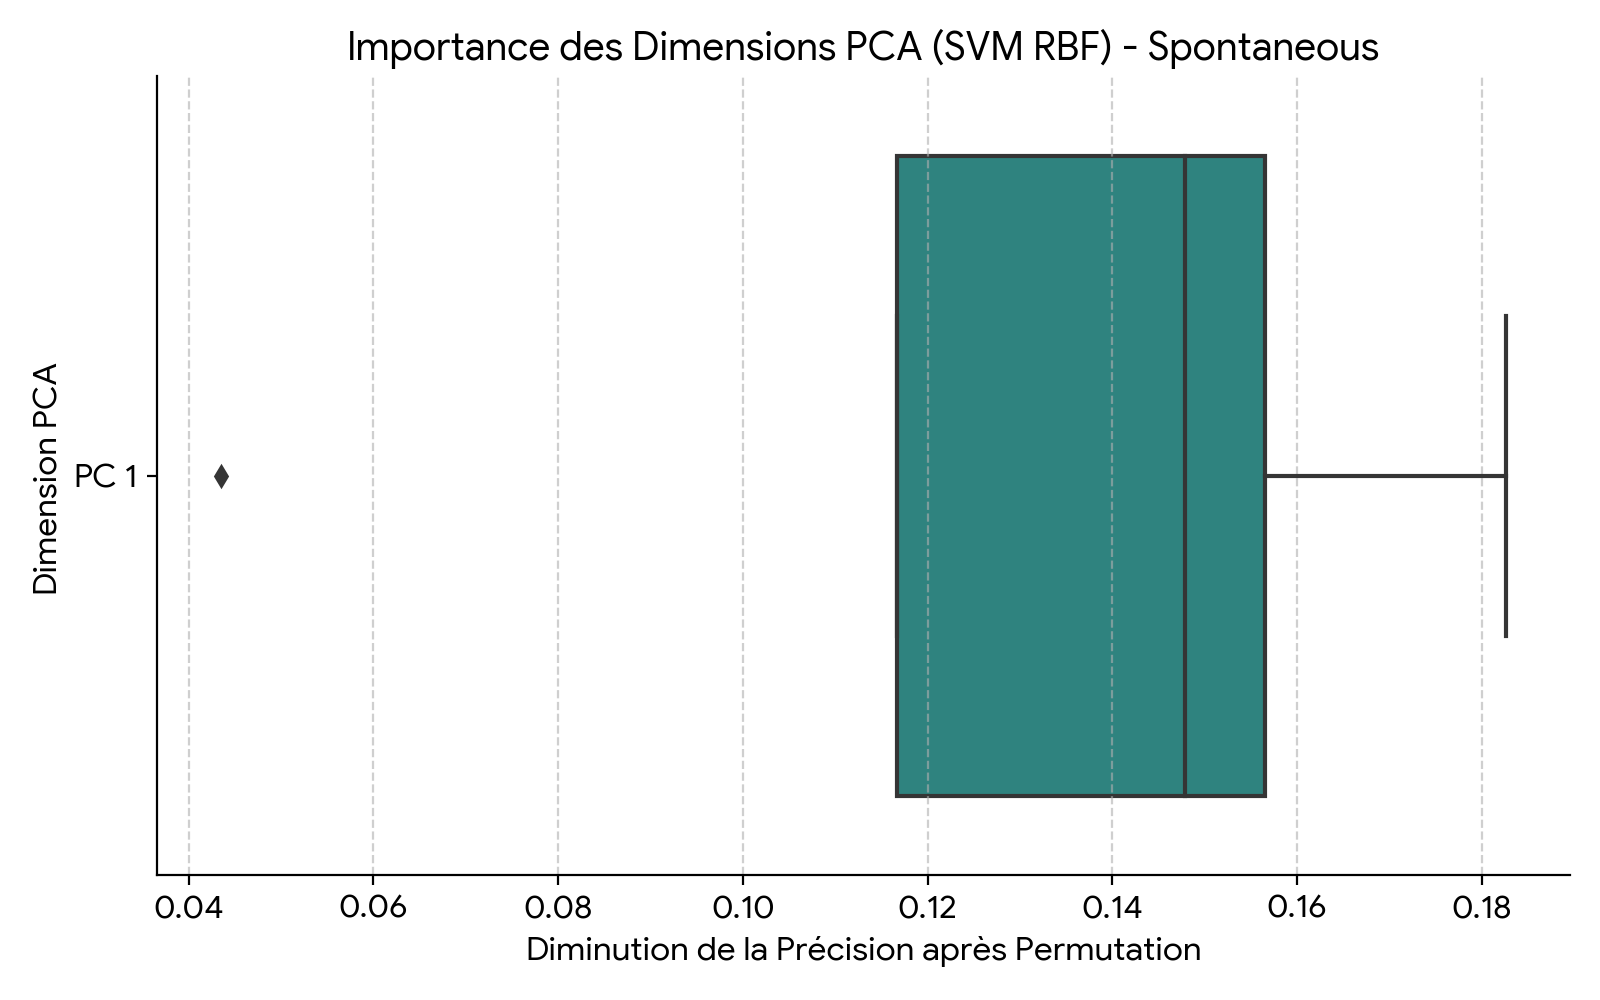

**Q.12 Based on the *importance* of each PCA component, write a short paragraph about the impact on speech - as generalized by the model.**

The addition of Principal Component Analysis (PCA) revealed that the original 32 acoustic features of spontaneous speech were highly redundant, with most of the variance (90%) captured by a single principal component (PC 1). Permutation importance analysis confirmed the complete dominance of this dimension, with its permutation resulting in a significant drop in accuracy ($\mathbf{12.94\%}$). This extreme concentration of predictive power on $\text{PC 1}$ means that the impact of depression, as generalized by the model, boils down to a single combined dimension of speech. This single dimension is heavily weighted by variations in Fundamental Frequency ($\text{F0final\_sma}$) and Vocal Quality, indicating that the most essential signature of depression in speech is an altered and consistent pattern of pitch and vocal production. The model therefore suggests that, despite the complexity of the 32 measures, the critical information is one-dimensional.